In [ ]:
#!pip3 install scikeras

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.optimizers import Adam, SGD, RMSprop

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from scikeras.wrappers import KerasClassifier

ModuleNotFoundError: No module named 'keras'

##Data Preparation


In [ ]:
# Functions I found and adjusted to help with data prep
# https://medium.com/@john.kosinski/preparing-and-shaping-timeseries-data-for-keras-lstm-input-part-two-ad17f6ab450

# extract X with the given number of timesteps
# df: the DataFrame
# ntimesteps: number of timesteps
#
def extract_X(df: pd.DataFrame, ntimesteps: int):
    features = len(df.columns)
    X = list()

    #offset for timesteps
    offsets = list()
    for i in range (ntimesteps, 0, -1):
        offsets.append(df.shift(i))

    #combine timestep columns into rows
    combined = pd.concat(offsets, axis=1)
    combined = combined.tail(-ntimesteps)
    combined.drop(combined.tail(1).index, inplace=True)

    #reshape each row (timesteps, features)
    for i in range(len(combined)):
        row = combined.iloc[i].to_numpy()
        xrow = list()
        for n in range(ntimesteps):
            xrow.append(row[n*features:(n*features)+features])
        X.append(xrow)

    #return as numpy array
    return np.array(X)

# extract y column (the col to be predicted)
# df: the DataFrame
# col_name: the name of the column to be predicted
# ntimesteps: number of timesteps
#
def extract_y(df: pd.DataFrame, col_name: str, ntimesteps: int):
    shifted = df.shift(-1)
    shifted = shifted.head(-2)
    shifted = shifted.tail(-(ntimesteps-1))
    return shifted[col_name].values

class DataSet:
    def __init__(self, X, y):
        if X.ndim != 3:
            raise Exception("Expected a 3-dimensional array for X")
        if y.ndim != 1:
            raise Exception("Expected a 1-dimensional array for y")
        if len(X) != len(y):
            raise Exception("Length of X and y must be the same")

        self.X = X
        self.y = y

    def train_test_split(self, test_size=0.2):
        # Calculate the number of samples for testing
        num_samples = len(self.X)
        num_test_samples = int(num_samples * test_size)

        # Shuffle indices
        indices = np.random.permutation(num_samples)

        # Split indices into training and testing
        test_indices = indices[:num_test_samples]
        train_indices = indices[num_test_samples:]

        # Split X and y based on indices
        X_train, y_train = self.X[train_indices], self.y[train_indices]
        X_test, y_test = self.X[test_indices], self.y[test_indices]

        # Create DataSet objects for training and testing sets
        train_data_set = DataSet(X_train, y_train)
        test_data_set = DataSet(X_test, y_test)

        return train_data_set, test_data_set

    @property
    def size(self):
        return len(self.X)

In [ ]:
# load the dataset
df = pd.read_csv("/mnt/scratch/tairaeli/cse_dat/train.csv")

In [ ]:
# drop na values
df.dropna()

# calulate ratio
df['bid_ask_ratio'] = df['bid_size']/df['ask_size']

# create target variable
df["target_change"] = np.ones_like(df["target"])
df.loc[df["target"]<0,'target_change'] = -1

# Select features and target
selected_features = ['stock_id', 'ask_size', 'imbalance_size', 'matched_size', 'bid_size', 'bid_ask_ratio', 'reference_price']

# use only stock_id 0
df = df[df['stock_id'] == 0]
df_selected = df[selected_features]
target = df[['date_id', 'target_change']]

df_selected
target

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_selected)
# Convert scaled data back to a DataFrame
scaled_df = pd.DataFrame(data=scaled_data, columns=df_selected.columns)


timesteps = 15
# Format data for LSTM input (sample/batches, timesteps, features)
dataset = DataSet(extract_X(df_selected, timesteps), extract_y(target, 'target_change', timesteps))
dataset.X.shape

In [ ]:
np.random.seed = 156
# Split into train and test
tr_data, te_data = dataset.train_test_split(test_size = .1)
tr_data.X.shape

(23796, 15, 7)

## LSTM Model


In [ ]:
# Function to create LSTM model
def create_lstm_model(neurons=64, activation='relu',
                          optimizer='Adam', loss = 'binary_crossentropy',
                              learning_rate = 0.001):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation='relu'), input_shape=(timesteps, tr_data.X.shape[2])))
    model.add(Dense(1, activation=activation))

    # Set optimizer based on input string
    if optimizer == 'Adam':
        opt = Adam(learning_rate = learning_rate)
    elif optimizer == 'SGD':
        opt = SGD(learning_rate = learning_rate)
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate = learning_rate)
    else:
        raise ValueError("Unknown optimizer: " + optimizer)

    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

In [ ]:
# Define parameters for grid search
param_grid = {
    'neurons': [32, 64, 128],
    'activation': ['relu', 'tanh', 'sigmoid', 'linear','swish'],
    'optimizer': ['Adam', 'SGD', 'RMSprop'],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001]
}

# Create KerasClassifier wrapper
model = KerasClassifier(build_fn=create_lstm_model, epochs=20, verbose=0,
                        activation=['relu', 'tanh', 'sigmoid', 'linear','swish'],
                        neurons = [32, 64, 128],
                        learning_rate = [0.1, 0.01, 0.001, 0.0001])

# Perform grid search
# change n_jobs to -1 to parallelize or None to go one by one
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs = 6)
grid_result = grid.fit(tr_data.X, tr_data.y)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


##Testing

In [10]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

NameError: name 'grid_result' is not defined

Epoch 1/5
744/744 [==============================] - 33s 41ms/step - loss: 15.3983 - accuracy: 0.4892
Epoch 2/5
744/744 [==============================] - 31s 41ms/step - loss: 15.3983 - accuracy: 0.4892
Epoch 3/5
744/744 [==============================] - 31s 41ms/step - loss: 15.3983 - accuracy: 0.4892
Epoch 4/5
744/744 [==============================] - 32s 44ms/step - loss: 15.3983 - accuracy: 0.4892
Epoch 5/5
83/83 [==============================] - 2s 13ms/step - loss: 15.9702 - accuracy: 0.4718
Test Loss: 15.97018051147461
Test Accuracy: 0.47181233763694763
83/83 [==============================] - 1s 6ms/step


<Axes: >

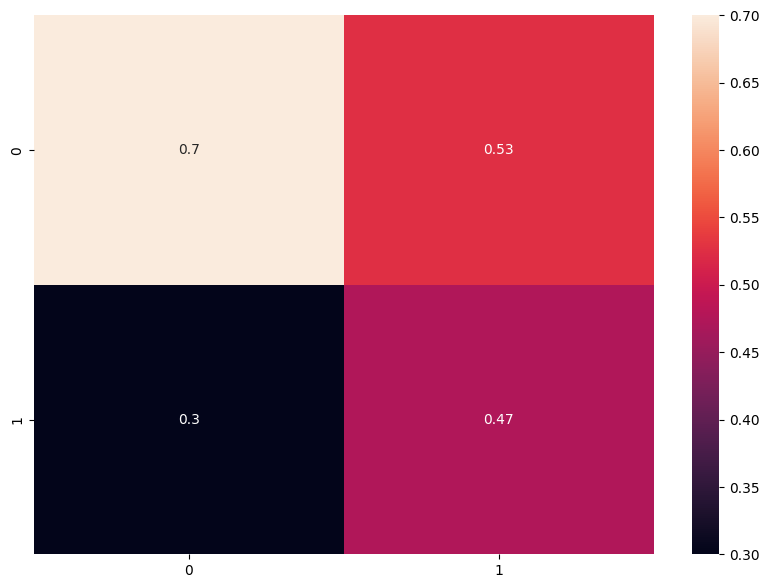

In [74]:
neurons = params['neurons']
activation = params['activation']
lr = params['learning_rate']
opt = params['optimizer']

model = create_lstm_model(neurons=neurons, activation=activation, learning_rate=lr, optimizer=opt)

# model = create_lstm_model(neurons=128, activation='tanh', learning_rate=0.001, optimizer='Adam')
model.fit(tr_data.X, tr_data.y, epochs=20, verbose=1)

loss, accuracy = model.evaluate(te_data.X, te_data.y)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

y_pred = model.predict(te_data.X)
cm = confusion_matrix(te_data.y, y_pred , normalize='pred')
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [79]:
f1_score = f1_score(y_pred, te_data.y)
print(f'F1-Score: {f1_score}')

mae = mean_absolute_error(y_pred, te_data.y)
print(f'MAE: {mae}')

F1-Score: 0.6422868915786762
MAE: 1.0510783200908058
